In [1]:
# import kagglehub, os
#
# # Download latest version
# path = kagglehub.dataset_download("pkdarabi/brain-tumor-image-dataset-semantic-segmentation")
#
# print("Path to dataset files:", path)

ERROR! Session/line number was not unique in

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import tensorflow as tf
import random

In [3]:
train_dir = os.path.join(os.getcwd(), "Data/brain-tumor-image-dataset-semantic-segmentation/versions/1/train")
val_dir = os.path.join(os.getcwd(), "Data/brain-tumor-image-dataset-semantic-segmentation/versions/1/valid")
test_dir = os.path.join(os.getcwd(), "Data/brain-tumor-image-dataset-semantic-segmentation/versions/1/test")

train_annotation = os.path.join(train_dir, '_annotations.coco.json')
val_annotation = os.path.join(val_dir, '_annotations.coco.json')
test_annotation = os.path.join(test_dir, '_annotations.coco.json')

train_coco = COCO(train_annotation)
val_coco = COCO(val_annotation)
test_coco = COCO(test_annotation)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
def load_image_and_mask(coco, image_dir, image_id):
    #Retrieving image information from COCO
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])

    # Loading image
    image = Image.open(image_path)
    image = np.array(image, dtype=np.uint8)

    # Create mask
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

# Create Tensorflow Dataset

In [5]:
def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),  # Image
            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)       # Mask
        )
    )

In [6]:
train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

## Normalization & Resize & change dims of mask

In [7]:
def preprocess(image, mask):
    # Resizing
    image = tf.image.resize(image, (256, 256))

    # Adding a channel size to a mask
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256, 256))

    # Normalization
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) # no normalization because masks are binary

    return image, mask

In [8]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [9]:
def visualize_dataset(dataset, num_samples=5):
    # Select a specific number of sample images and masks from the dataset
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.figure(figsize=(10, 5))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")

        # Show mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()

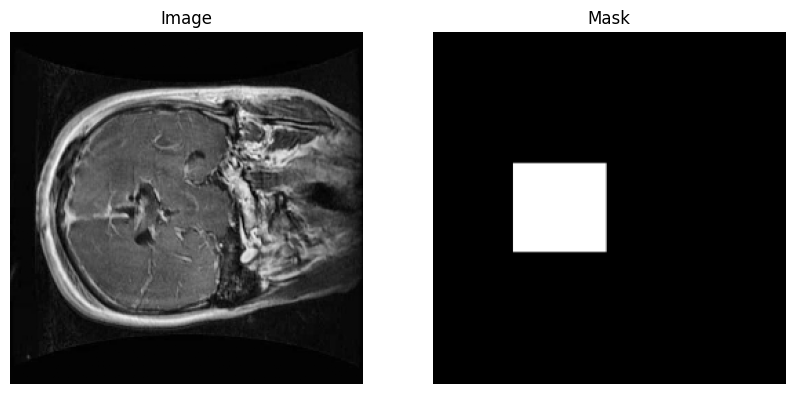

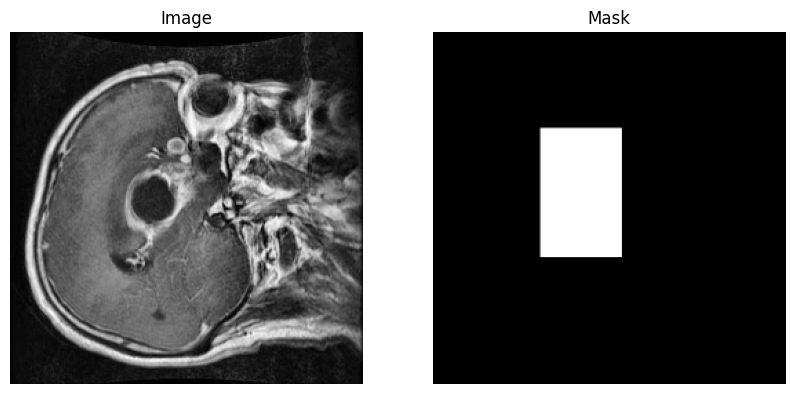

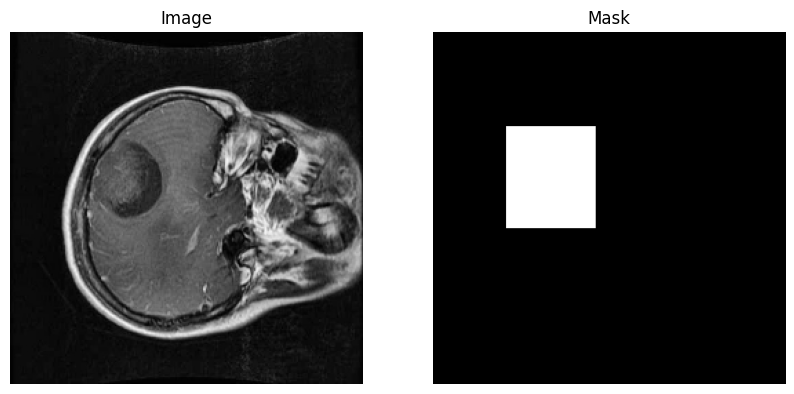

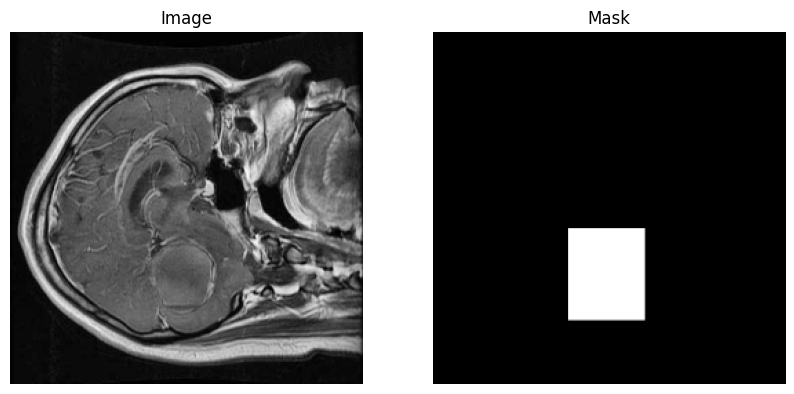

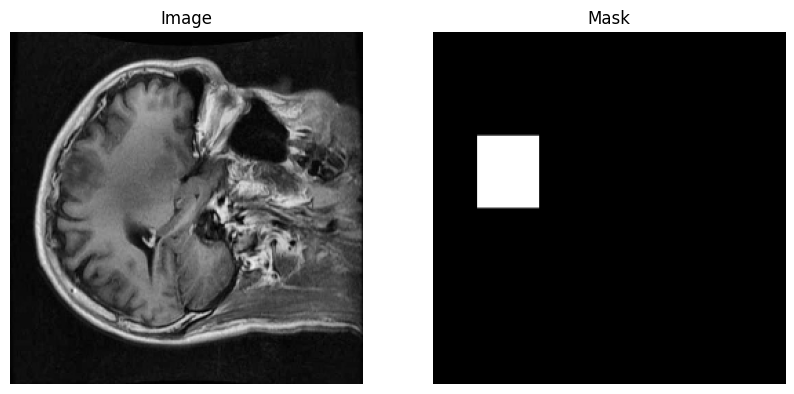

In [10]:
visualize_dataset(train_dataset)

In [11]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
def downsampling_block(inputs, n_filters, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block.

    Args:
        inputs: Input tensor.
        n_filters: Number of filters for convolutional layers.
        dropout_prob: Dropout probability.
        max_pooling: Whether to apply max pooling.

    Returns:
        next_layer: Output tensor for the next layer.
        skip_connection: Skip connection tensor.
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    next_layer = MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv
    return next_layer, conv

In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Convolutional upsampling block.

    Args:
        expansive_input: Input tensor from previous layer.
        contractive_input: Skip connection tensor from encoding path.
        n_filters: Number of filters for convolutional layers.

    Returns:
        Output tensor after upsampling and convolution.
    """
    up = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [14]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    """
    U-Net model implementation.

    Args:
        input_size: Shape of the input tensor.
        n_filters: Number of filters for the convolutional layers.
        n_classes: Number of output classes.

    Returns:
        U-Net model.
    """
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    dblock1 = downsampling_block(inputs, n_filters)
    dblock2 = downsampling_block(dblock1[0], n_filters * 2)
    dblock3 = downsampling_block(dblock2[0], n_filters * 4)
    dblock4 = downsampling_block(dblock3[0], n_filters * 8)
    dblock5 = downsampling_block(dblock4[0], n_filters * 16)
    #Bottleneck
    bblock6 = downsampling_block(dblock5[0], n_filters * 32, dropout_prob=0.4, max_pooling=False)

    # Expanding Path (Decoder)
    ublock7 = upsampling_block(bblock6[0], dblock5[1], n_filters * 16)
    ublock8 = upsampling_block(ublock7, dblock4[1], n_filters * 8)
    ublock9 = upsampling_block(ublock8, dblock3[1], n_filters * 4)
    ublock10 = upsampling_block(ublock9, dblock2[1], n_filters * 2)
    ublock11 = upsampling_block(ublock10, dblock1[1], n_filters)

    # Output Layer
    conv12 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock11)
    outputs = Conv2D(n_classes, 1, activation="sigmoid", padding="same")(conv12)

    return Model(inputs=inputs, outputs=outputs)

In [15]:
from tensorflow.keras import backend as K

In [16]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

In [17]:
model = unet_model(n_filters=32)


metrics = ["accuracy", dice_coef]

initial_learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_4[

 Total params: 34,595,585 (131.97 MB)

 Trainable params: 34,595,585 (131.97 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Optimizing datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Steps calculating
steps_per_epoch = len(train_coco.getImgIds()) // BATCH_SIZE
validation_steps = len(val_coco.getImgIds()) // BATCH_SIZE
test_steps = len(test_coco.getImgIds()) // BATCH_SIZE

In [20]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9916730106021831187
xla_global_id: -1
]


'2.19.0'

In [22]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 593s 6s/step - accuracy: 0.8562 - dice_coef: 0.1064 - loss: 0.6719 - val_accuracy: 0.9155 - val_dice_coef: 0.2639 - val_loss: 0.5026 - learning_rate: 1.0000e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.9301 - dice_coef: 0.2851 - loss: 0.4928 - val_accuracy: 0.9361 - val_dice_coef: 0.3582 - val_loss: 0.4559 - learning_rate: 1.0000e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 519s 6s/step - accuracy: 0.9483 - dice_coef: 0.3642 - loss: 0.4437 - val_accuracy: 0.9537 - val_dice_coef: 0.4309 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 513s 6s/step - accuracy: 0.9571 - dice_coef: 0.4375 - loss: 0.3949 - val_accuracy: 0.9650 - val_dice_coef: 0.5010 - val_loss: 0.3438 - learning_rate: 1.0000e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.9639 - dice_coef: 0.5111 - loss: 0.3447 - val_accuracy: 0.9718 - val_dice_coef: 0.5387 - val_loss: 0.3204 - learning_rate: 1.0000e-04
Epoch

In [23]:
test_loss, test_accuracy, test_coef = model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9812 - dice_coef: 0.7513 - loss: 0.1874
Test Loss: 0.18144308030605316, Test Accuracy: 0.9824880361557007, Test Dice Coefficient: 0.7561541199684143


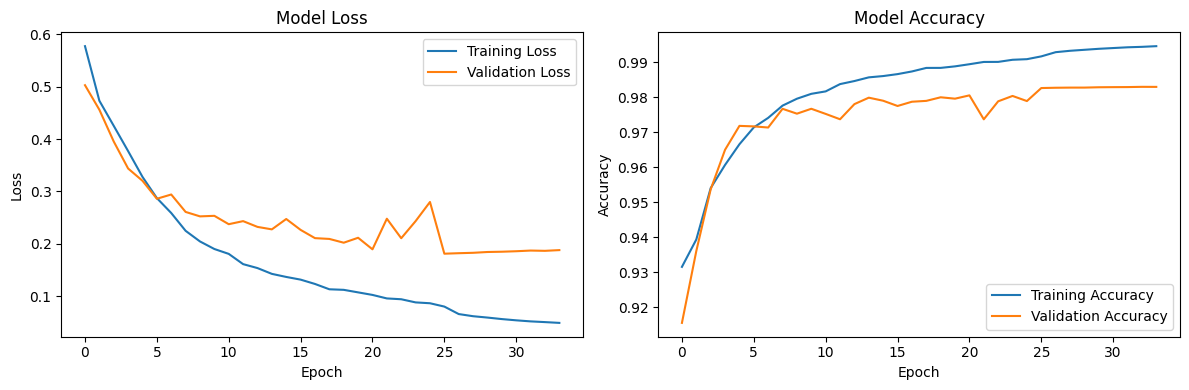

In [24]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss graph
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy graph
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [25]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    # Select a random batch
    random_batch = random.choice(list(dataset))
    images, masks = random_batch

    # Select random indices for num_samples
    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    predictions = model.predict(images)

    # Binarizing prediction masks
    binary_predictions = (predictions > threshold).astype('uint8')

    for i in indices:
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


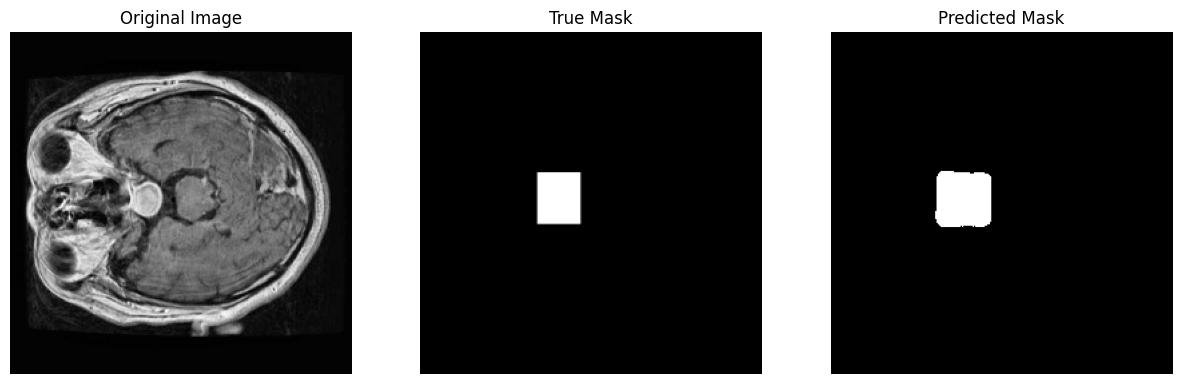

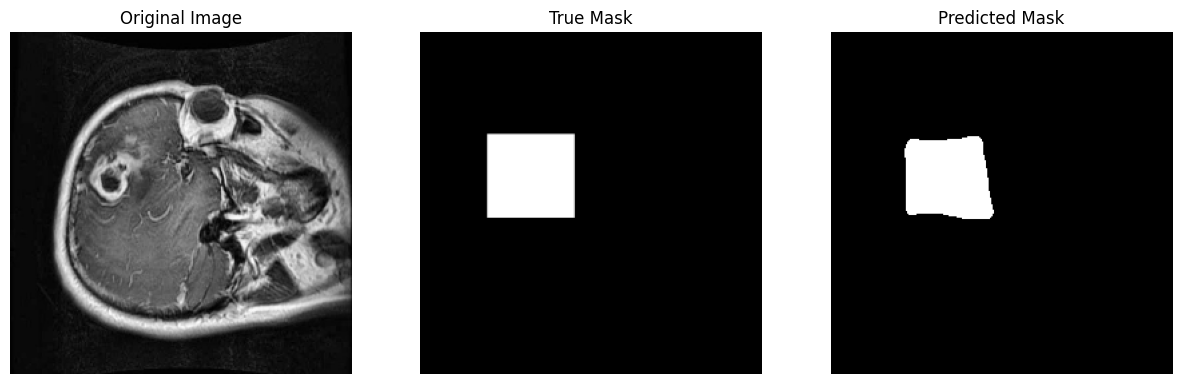

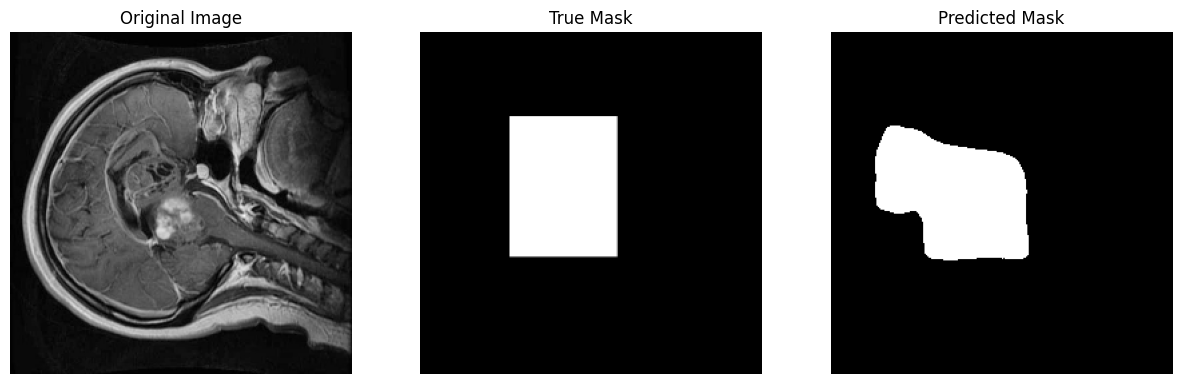

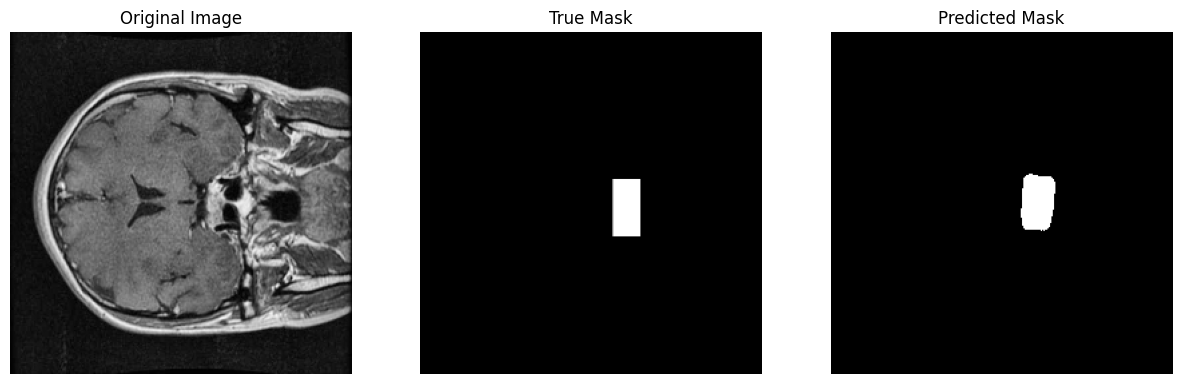

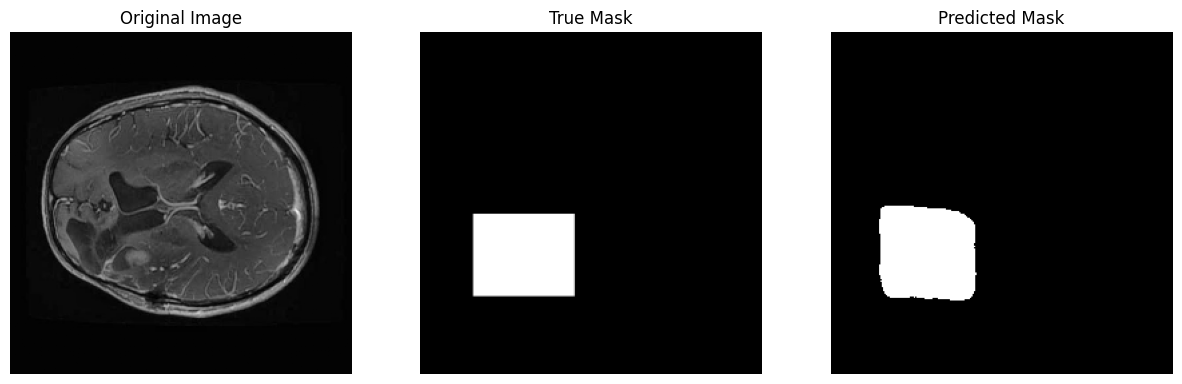

In [26]:
visualize_predictions(model, test_dataset)